# Install Dependencies
---

In [1]:
# for installing packages using legacy code
!pip install setuptools

# The environment we will be working with
!pip install git+https://github.com/ParisaAligol/CityLearn-EVModel-Parisa@develop-ev

# For participant interactions (buttons)
!pip install ipywidgets

# To generate static figures
!pip install matplotlib
!pip install seaborn

# Provide standard RL algorithms
!pip install stable_baselines3
! pip install shimmy


  Cloning https://github.com/ParisaAligol/CityLearn-EVModel-Parisa (to revision develop-ev) to /tmp/pip-req-build-fym0h53_
  Running command git clone --filter=blob:none --quiet https://github.com/ParisaAligol/CityLearn-EVModel-Parisa /tmp/pip-req-build-fym0h53_
  Running command git checkout -b develop-ev --track origin/develop-ev
  Switched to a new branch 'develop-ev'
  Branch 'develop-ev' set up to track remote branch 'develop-ev' from 'origin'.
  Resolved https://github.com/ParisaAligol/CityLearn-EVModel-Parisa to commit b0aa72025fd091d2f3b90c1a59605fff0c78d48a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.2 MB/s eta 0:00:00
  Created wheel for CityLearn: filename=CityLearn-2.0b3-py3-none-any.whl size=16688450 sha256=d0268af55603c314040b6d2fba3e30f93fe0f03612f9c7437

# Import Dependencies
---

In [2]:
import os
import numpy as np
import pandas as pd
import shutil
from stable_baselines3 import SAC
from citylearn.agents.rbc import BasicRBC
from citylearn.callback import SaveDataCallback
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.energy_model import ElectricVehicle, ZERO_DIVISION_CAPACITY
from citylearn.reward_function import RewardFunction
from citylearn.utilities import read_json, write_json
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [15]:
from google.colab import files

# Use the files.upload() function to upload a file
uploaded = files.upload()

Saving schema.json to schema.json
Saving Building_7.csv to Building_7.csv
Saving Building_6.csv to Building_6.csv
Saving Building_5.csv to Building_5.csv
Saving Building_4.csv to Building_4.csv
Saving Building_3.csv to Building_3.csv
Saving Building_2.csv to Building_2.csv
Saving Building_1.csv to Building_1.csv
Saving weather.csv to weather.csv
Saving Building_1_EV_5.csv to Building_1_EV_5.csv
Saving Building_2_EV_1.csv to Building_2_EV_1.csv
Saving Building_2_EV_2.csv to Building_2_EV_2.csv
Saving Building_2_EV_3.csv to Building_2_EV_3.csv
Saving Building_4_EV_1.csv to Building_4_EV_1.csv
Saving Building_4_EV_2.csv to Building_4_EV_2.csv
Saving Building_4_EV_3.csv to Building_4_EV_3.csv
Saving Building_4_EV_4.csv to Building_4_EV_4.csv
Saving Building_4_EV_5.csv to Building_4_EV_5.csv
Saving Building_6_EV_1.csv to Building_6_EV_1.csv
Saving Building_6_EV_2.csv to Building_6_EV_2.csv
Saving Building_6_EV_3.csv to Building_6_EV_3.csv
Saving Building_6_EV_4.csv to Building_6_EV_4.csv
Sa

In [17]:
# Specify the destination directory path in the Colab environment
destination_directory = '/usr/local/lib/python3.10/dist-packages/citylearn/data/citylearn_challenge_2023_phase_2/'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Move the uploaded file to the destination directory
for filename, content in uploaded.items():
    file_path = os.path.join(destination_directory, filename)
    with open(file_path, 'wb') as f:
        f.write(content)

print("File moved to the specific directory successfully.")

File moved to the specific directory successfully.


In [18]:
SCHEMA_TEMPLATE = 'citylearn_challenge_2023_phase_2'
TARGET_DATASET_DIRECTORY = 'ev_test_data'
SCHEMA_FILEPATH = os.path.join(TARGET_DATASET_DIRECTORY, SCHEMA_TEMPLATE, 'schema.json')

# Create Test Dataset
---

In [19]:
# Copy an existing dataset
if os.path.isdir(TARGET_DATASET_DIRECTORY):
    shutil.rmtree(TARGET_DATASET_DIRECTORY)
else:
    pass

DataSet.copy(SCHEMA_TEMPLATE, TARGET_DATASET_DIRECTORY)
schema = read_json(SCHEMA_FILEPATH)



In [20]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_building_guide(env):
    """Plots building load and generation profiles."""

    column_count_limit = 4
    building_count = len(env.buildings)
    row_count = math.ceil((building_count + 1) / column_count_limit)  # Add 1 for the sum chart
    column_count = min(column_count_limit, building_count)
    figsize = (4.0 * column_count, 1.75 * row_count)
    fig, axes = plt.subplots(row_count, column_count, figsize=figsize)

    # Calculate the sum of the total for each time step across all buildings
    total_sum = [0] * len(env.buildings[0].energy_simulation.non_shiftable_load)
    for b in env.buildings:
        total_sum = [total_sum[i] + b.energy_simulation.non_shiftable_load[i] for i in range(len(total_sum))]

    for i, (ax, b) in enumerate(zip(axes.flat, env.buildings)):
        y1 = b.energy_simulation.non_shiftable_load
        y2 = b.pv.get_generation(b.energy_simulation.solar_generation)
        x = range(len(y1))
        ax.plot(x, y1, label='Load')
        ax.plot(x, y2, label='Generation')
        ax.set_title(b.name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('kWh')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
        else:
            ax.legend().set_visible(False)

    # Create a new subplot for the sum chart
    ax_sum = axes.flat[-1]
    ax_sum.plot(x, total_sum, label='Total Sum', color='red')
    ax_sum.set_title('Total Sum')
    ax_sum.set_xlabel('Time step')
    ax_sum.set_ylabel('kWh')
    ax_sum.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax_sum.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    # Hide any remaining empty subplots
    for ax in axes.flat[building_count:]:
        ax.set_visible(False)

    plt.tight_layout()
    return fig


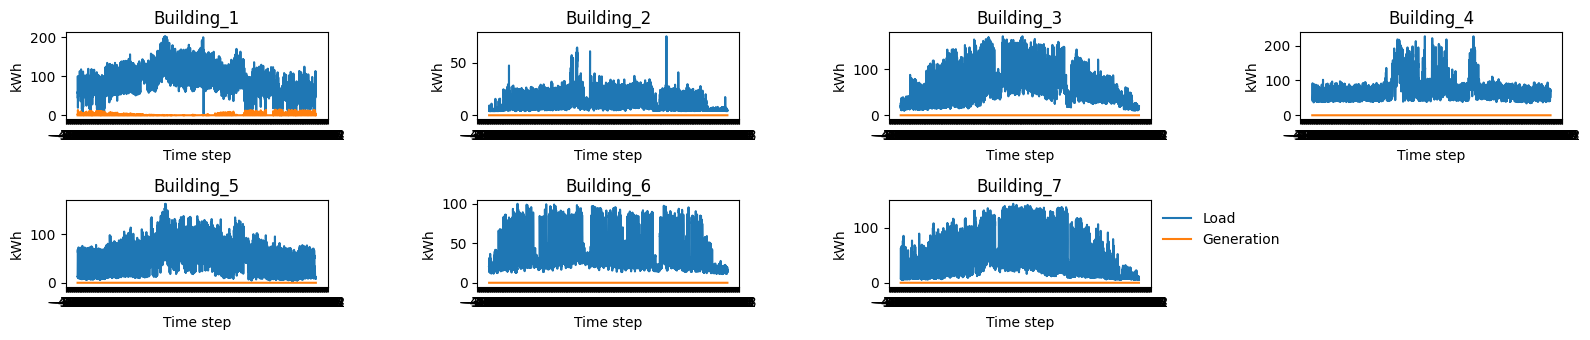

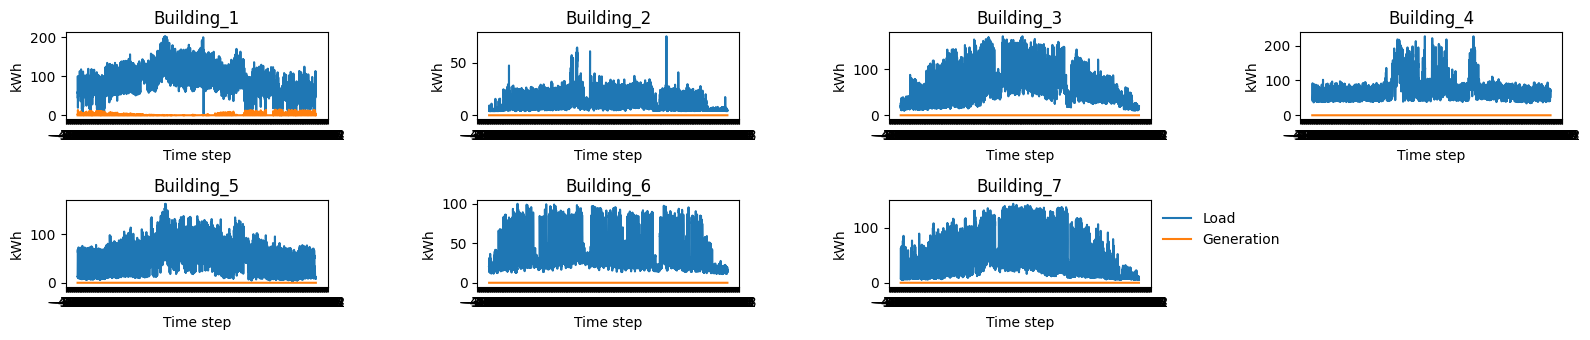

In [21]:
plot_building_guide(env)

# Test Simulation
---

## RBC

In [22]:
env = CityLearnEnv(SCHEMA_FILEPATH)
model = BasicRBC(env)
model.learn(episodes=1)
display(env.evaluate())

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,cost_function,value,name,level
0,annual_peak_average,0.961120,District,district
1,carbon_emissions_total,1.008554,District,district
2,cost_total,0.992733,District,district
3,daily_peak_average,1.134220,District,district
4,discomfort_delta_average,0.000000,District,district
...,...,...,...,...
79,discomfort_too_cold_proportion,NaN,Building_7,building
80,discomfort_too_hot_proportion,NaN,Building_7,building
81,discomfort_delta_minimum,0.000000,Building_7,building
82,discomfort_delta_maximum,0.000000,Building_7,building


## SB3 SAC

In [23]:
class CustomReward(RewardFunction):
    def __init__(self, env: CityLearnEnv):
        super().__init__(env)

    def calculate(self):
        reward_list = []

        for b in self.env.buildings:
            e = b.net_electricity_consumption[-1]
            reward = 0.0

            for s in [b.electrical_storage] + b.electric_vehicles:
                if not isinstance(s, ElectricVehicle) or (isinstance(s, ElectricVehicle) and s.schedule.availability[-1] == 1):
                    c = s.capacity_history[0]
                    s = s.soc[-1]/c
                    reward += -(1.0 + np.sign(e)*s)*abs(e) if c > ZERO_DIVISION_CAPACITY else 0.0
                else:
                    pass

            reward_list.append(reward)

        if self.env.central_agent:
            reward = [sum(reward_list)]
        else:
            reward = reward_list

        return reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# train
episodes = 10
env = CityLearnEnv(SCHEMA_FILEPATH, central_agent=True)
env.reward_function = CustomReward(env) # set custom reward
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)
model = SAC('MlpPolicy', env, learning_rate=0.005, learning_starts=env.unwrapped.time_steps, tau=0.05, gamma=0.9)
callback = SaveDataCallback(env, 'citylearn_ev', 'results')
model.learn(total_timesteps=episodes*env.unwrapped.time_steps, callback=callback)

# evaluate
observations = env.reset()
done = False

while not env.done:
    print(f'\rTime step: {env.time_step + 1}/{env.time_steps}', end=' '*50)
    actions, _ = model.predict(observations, deterministic=True)
    observations, reward, done, _ = env.step(actions)

display(env.evaluate())

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, ax

Time step: 8759/8760                                                  

,cost_function,value,name,level
0,annual_peak_average,0.991472,District,district
1,carbon_emissions_total,0.992314,District,district
2,cost_total,0.994666,District,district
3,daily_peak_average,0.998822,District,district
4,discomfort_delta_average,0.000000,District,district
...,...,...,...,...
79,discomfort_too_cold_proportion,NaN,Building_7,building
80,discomfort_too_hot_proportion,NaN,Building_7,building
81,discomfort_delta_minimum,0.000000,Building_7,building
82,discomfort_delta_maximum,0.000000,Building_7,building


In [11]:
RANDOM_SEED = 0
print('Random seed:', RANDOM_SEED)

Random seed: 0


In [26]:
model.save('modelnew.zip')

In [12]:
# edit next code line to change number of buildings in simulation
building_count = 7

 # edit next code line to change number of days in simulation
day_count = 7

# edit next code line to change active observations in simulation
active_observations = ['hour']

schema, buildings = set_schema_buildings(schema, building_count, RANDOM_SEED)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, day_count, RANDOM_SEED)
schema, active_observations =\
    set_active_observations(schema, active_observations)

print('Selected buildings:', buildings)
print(
    f'Selected {day_count}-day period time steps:',
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', active_observations)

NameError: ignored

In [13]:
def set_schema_buildings(
schema: dict, count: int, seed: int
) -> Tuple[dict, List[str]]:
    """Randomly select number of buildings to set as active in the schema.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with active buildings set.
    buildings: List[str]
        List of selected buildings.
    """

    assert 1 <= count <= 15, 'Count must be between 1 and 15.'

    # set random seed
    np.random.seed(seed)

    # get all building names
    buildings = list(schema['buildings'].keys())

    # remove buildins 12 and 15 as they have pecularities in their data
    # that are not relevant to this tutorial
    buildings_to_exclude = ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, size=count, replace=False).tolist()

    # reorder buildings
    building_ids = [int(b.split('_')[-1]) for b in buildings]
    building_ids = sorted(building_ids)
    buildings = [f'Building_{i}' for i in building_ids]

    # update schema to only included selected buildings
    for b in schema['buildings']:
        if b in buildings:
            schema['buildings'][b]['include'] = True
        else:
            schema['buildings'][b]['include'] = False

    return schema, buildings

NameError: ignored